<a href="https://colab.research.google.com/github/vcepaitis/SSI_EF2_2023/blob/main/GraphAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/pdf/2012.00173.pdf

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  17.9M      0 --:--:--  0:00:18 --:--:-- 25.0M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_

In [2]:
# Helper function for visualization.
import matplotlib.pyplot as plt
%matplotlib inline
# Numpy, h5py, etc
import numpy as np
import h5py

def print_device_usage(device):
  tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
  reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
  allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
  free_memory = reserved_memory-allocated_memory  # free inside reserved
  print('Total memory in Gb: %.2f'%tot_memory)
  print('Reserved memory in Gb: %.2f'%reserved_memory)
  print('Allocated memory in Gb: %.2f'%allocated_memory)
  print('Free memory in Gb: %.2f'%free_memory)


# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)

device :  cuda:0
Total memory in Gb: 14.75
Reserved memory in Gb: 0.00
Allocated memory in Gb: 0.00
Free memory in Gb: 0.00


In [3]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


In [4]:
target = np.array([])
jetList = np.array([])
jetImages = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
            #  'jetImage_7_100p_10000_20000.h5',
            #  'jetImage_7_100p_30000_40000.h5',
            #  'jetImage_7_100p_40000_50000.h5',
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    jetImages_file = np.array(f.get('jetImage'))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target = np.concatenate([target, target_file], axis=0) if target.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    del jetList_file, target_file, jetImages_file
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

target_plot = np.argmax(target, axis=1)
label_names= ["gluon", "quark", "W", "Z", "top"]
# features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_to_consider = 'eta,pt,phi'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
print(features_names)
print(features_to_consider)
jetList = jetList[:,:,features_idx]

Appending jetImage_7_100p_0_10000.h5
{'px': 0, 'py': 1, 'pz': 2, 'e': 3, 'erel': 4, 'pt': 5, 'ptrel': 6, 'eta': 7, 'etarel': 8, 'etarot': 9, 'phi': 10, 'phirel': 11, 'phirot': 12, 'deltaR': 13, 'costheta': 14, 'costhetarel': 15}
['eta', 'pt', 'phi']


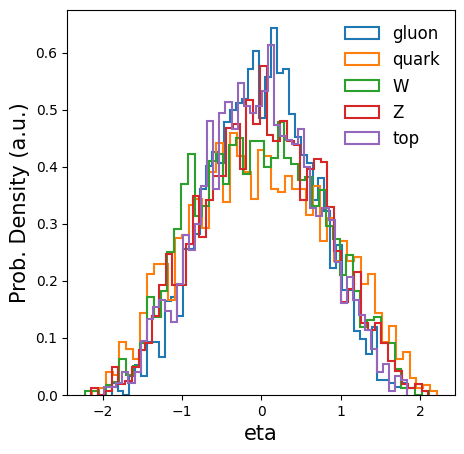

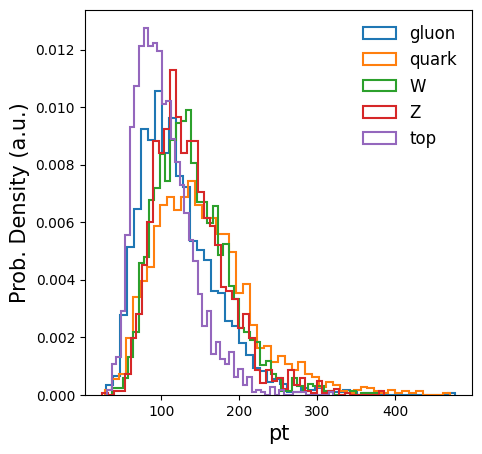

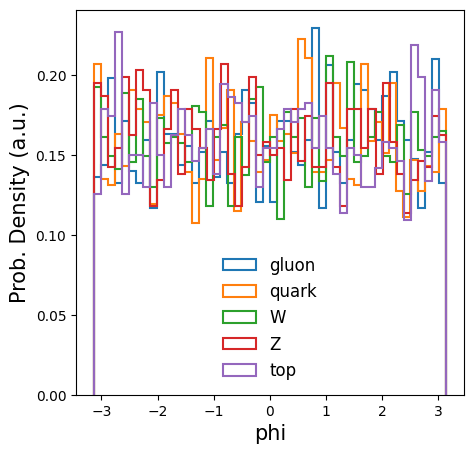

In [5]:
#Let's define a helper function to plot the distibutions
def plot_features(feat_idx, input_data, features_to_consider):
    plt.subplots(figsize=(5,5))
    for jet_type_idx in range(len(label_names)):
        data_feature = input_data[:,:,feat_idx]
        data_feature = data_feature[target_plot == jet_type_idx]
        # then plot the right quantity for the reduced array (merge all constituents together)
        plt.hist(data_feature[:,feat_idx].flatten(), bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
    #plt.yscale('log', nonposy='clip')
    plt.legend(label_names, fontsize=12, frameon=False)
    plt.xlabel(features_to_consider[feat_idx], fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

# we now plot all the features
for i in range(len(features_to_consider)):
    plot_features(i, jetList, features_to_consider)


In [6]:
from torch_geometric.data import Data

remove_padding = False # remove zero-padded particles
jetList = jetList[target_plot == 4]
num_jets = np.minimum(50000, len(jetList)) #number of training+validation samples. We can start with 10000.
jet_dataset = []
print(features_to_consider.index('pt'))
mask_real = np.where(jetList[1,:,features_to_consider.index('pt')]>0)
max_pt = np.max(jetList[:,:,features_to_consider.index('pt')])
print(jetList[1,mask_real,:].shape)
for i_jet in range(num_jets):
    # remove the zero padded particles
    if remove_padding:
        mask_real = np.where(jetList[i_jet,:,features_to_consider.index('pt')]>0) # keep only particles where energy is > 0. e.g. real particles
        num_nodes = len(mask_real[0])
        d = Data(x=torch.tensor(jetList[i_jet,mask_real,:].squeeze(), dtype=torch.float),
                y=torch.tensor(target[i_jet], dtype=torch.long),
                num_nodes = num_nodes)
    else:
        num_nodes = 10
        d = Data(x=torch.tensor(jetList[i_jet,:num_nodes,:].squeeze(), dtype=torch.float),
                y=torch.tensor(target[i_jet], dtype=torch.long),
                num_nodes = num_nodes)
        d.x[:,features_to_consider.index('pt')] = d.x[:,features_to_consider.index('pt')]/max_pt*3
    # typically we do no need to set the num_nodes explicitely and it is inferred automatically from the edge_index.
    # however, in this case we do not pass edge_index, since we will build the graph dynamically inside the network, so we need to pass num_nodes.
    jet_dataset.append(d)

print(jet_dataset[:10])

1
(1, 65, 3)
[Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10), Data(x=[10, 3], y=[5], num_nodes=10)]


In [7]:
from torch import nn
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch_cluster import knn_graph
import torch.nn.functional as F

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super().__init__()

        self.lambd = lambd

    def forward(self, x, y):
        return self.lambd(x, y)

class ParticleNetEdgeNet(nn.Module):

    def __init__(self, in_size, layer_size):
        super().__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size)) #undirected graph, take 2 nodes as input
        # layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.LeakyReLU())

        for i in range(1):
            layers.append(nn.Linear(layer_size, layer_size))
            # layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.LeakyReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)


class ParticleNet(nn.Module):

    def __init__(self, node_feat_size, num_classes=5):
        super().__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = 5 #for kNN algo
        self.num_edge_convs = 2 #number of stacked EdgeConv blocks
        self.kernel_sizes = [16, 16] #16, #number of units in the three linear transformation layers in each EdgeConv block
        self.fc_size = int(num_nodes * 5) #units of the first FC layer after EdgeConv blocks
        self.dropout = 0.1

        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()
        self.edge_nets_deconv = nn.ModuleList()
        self.edge_deconvs = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes) #inputs include also previous layer output

        #the first EdgeConv block
        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1])) # add one of the ParticleNetEdgeNet at the time
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        #the deconvolutional EdgeConv block
        self.edge_nets_deconv.append(ParticleNetEdgeNet(int(self.fc_size/num_nodes), 3)) # add one of the ParticleNetEdgeNet at the time
        self.edge_deconvs.append(EdgeConv(self.edge_nets_deconv[-1], aggr="mean"))

        #stack other two EdgeConv blocks
        for i in range(1, self.num_edge_convs):
            # print("self.num_edge_convs",i)
            # ATTENTION !!!
            # adding kernel sizes because of skip connections
            # check the forward function to see how the skip connections are implemented
            self.edge_nets.append(
                ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i + 1])
            )
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.concat_layer = LambdaLayer(lambda x, y: torch.cat((x, y), dim=1))
        self.global_pool = LambdaLayer(lambda x, y: global_mean_pool(x, y))

        self.ff_compress = nn.Sequential(nn.Linear(self.output_sizes[-1], 4))

        self.fc1 = nn.Sequential(nn.Linear(4, self.fc_size)) # self.output_sizes[-1]

        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.fc2 = nn.Sequential(nn.Linear(int(self.fc_size/num_nodes), self.node_feat_size))

        # self.fc3 = nn.Sequential(nn.Linear(self.node_feat_size, self.node_feat_size))

    def forward(self, data):
        # input data is an instance of PyG Data()
        x = data.x
        batch = data.batch # indicates to which graph the node belongs

        # y = self.fc3(x)
        # return y

        for i in range(self.num_edge_convs):
            # using only angular coords eta and phi for knn in the first edgeconv block, computing edge_index.
            edge_index = (
                knn_graph(x[:, :2], self.k, batch) if i == 0 else knn_graph(x, self.k, batch)
            )
            # print(x.shape)
            # print(edge_index.shape)
            y = self.edge_convs[i](x, edge_index)
            x = self.concat_layer(y, x) # concatenating with original features i.e. skip connection
            # edge_convs passes a vector with dimension (number_of_edges, 2 * number_of_features) where in each column there is [x_i, x_i-x_j]
            # the new embedding of each note is calculated

        x = self.global_pool(x, batch) # this runs scatter under the hood

        # print(x.shape)
        # x = x.repeat(30,1)
        # print(x.shape)
        x = self.ff_compress(x)
        x = self.fc1(x).reshape(-1, int(self.fc_size/num_nodes))
        x = torch.nn.functional.leaky_relu(x)
        # return x
        # edge_index = (knn_graph(x, self.k, batch))
        # x = self.edge_deconvs[0](x, edge_index)
        x = self.fc2(x)
        return x

In [8]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# split the resulting dataset in training and validation datasets
dataset_size = len(jet_dataset)
val_split = 0.1
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
jet_dataset_train, jet_dataset_val = train_test_split(jet_dataset,test_size = val_size,train_size = train_size, shuffle=True)

# create dataloaders
batch_size = 128
jets_loader_train = DataLoader(jet_dataset_train, batch_size=batch_size,shuffle=True)
jets_loader_val = DataLoader(jet_dataset_val, batch_size=batch_size,shuffle=False)

for data in jets_loader_train:
  print(data)
  print(data.y)
  break

DataBatch(x=[1280, 3], y=[640], num_nodes=1280, batch=[1280], ptr=[129])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

In [9]:
#Instantiate the model and move it to the device, define the optimizer and the loss function
print("number of features", len(features_to_consider))


class VerboseExecution(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

        # Register a hook for each layer
        for name, layer in self.model.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: output {output.shape}")
            )

        for name, layer in self.model.edge_convs.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: output {output.shape}")
            )

        for name, layer in self.model.edge_deconvs.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: output {output.shape}")
            )

        for name, layer in self.model.edge_nets.named_children():
            layer.__name__ = name
            layer.register_forward_hook(
                lambda layer, _, output: print(f"{layer.__name__}: output {output.shape}")
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

verbose_particle_net = VerboseExecution(ParticleNet(node_feat_size=len(features_to_consider), num_classes=10))

# print("acf: ", jet_dataset_train[0])
print("Input ", jet_dataset_train[0].x.shape)
print(verbose_particle_net(jet_dataset_train[0]).shape)
print("")
print("Dataloader: ", next(iter(jets_loader_val)))
print("out ", verbose_particle_net(next(iter(jets_loader_val))).shape)

# gnn.eval()
# with torch.no_grad():
#     gnn(jet_dataset_train[0]).shape

# for name, layer in gnn.edge_convs.named_children():
#     print(layer)

number of features 3
Input  torch.Size([10, 3])
0: output torch.Size([50, 16])
0: output torch.Size([10, 16])
concat_layer: output torch.Size([10, 19])
1: output torch.Size([50, 16])
1: output torch.Size([10, 16])
concat_layer: output torch.Size([10, 35])
global_pool: output torch.Size([1, 35])
ff_compress: output torch.Size([1, 4])
fc1: output torch.Size([1, 50])
fc2: output torch.Size([10, 3])
torch.Size([10, 3])

Dataloader:  DataBatch(x=[1280, 3], y=[640], num_nodes=1280, batch=[1280], ptr=[129])
0: output torch.Size([6400, 16])
0: output torch.Size([1280, 16])
concat_layer: output torch.Size([1280, 19])
1: output torch.Size([6400, 16])
1: output torch.Size([1280, 16])
concat_layer: output torch.Size([1280, 35])
global_pool: output torch.Size([128, 35])
ff_compress: output torch.Size([128, 4])
fc1: output torch.Size([128, 50])
fc2: output torch.Size([1280, 3])
out  torch.Size([1280, 3])


In [12]:
import tqdm
import torch.optim as optim

tot_iter = len(jets_loader_train)
# t = tqdm.tqdm(enumerate(jets_loader_train),total=tot_iter)
gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=10).to(device)
#print(gnn)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(gnn.parameters(), lr = 0.001)

for epoch in range(5000):
  batch_loss = []
  for i, data in enumerate(jets_loader_train):
    optimizer.zero_grad() # Clear gradients
    data = data.to(device)
    outputs = gnn(data) # Perform a single forward pass
    # print(data.x)
    # print(outputs)
    loss = loss_fn(outputs, data.x) # Compute the loss
    loss.backward()
    optimizer.step()
    batch_loss.append(loss.detach().cpu().numpy())
    break
  if epoch%20==0:
    print(f"Epoch {epoch}, loss {np.mean(batch_loss)}")


Epoch 0, loss 1.424580693244934
Epoch 20, loss 1.421169400215149
Epoch 40, loss 1.3997142314910889
Epoch 60, loss 1.159886360168457
Epoch 80, loss 1.1711211204528809
Epoch 100, loss 0.9443561434745789
Epoch 120, loss 0.8069385886192322
Epoch 140, loss 0.6293509006500244
Epoch 160, loss 0.4550669193267822
Epoch 180, loss 0.406047523021698
Epoch 200, loss 0.33564701676368713
Epoch 220, loss 0.2483271360397339
Epoch 240, loss 0.19492566585540771
Epoch 260, loss 0.2489931881427765
Epoch 280, loss 0.2439005970954895
Epoch 300, loss 0.19804857671260834
Epoch 320, loss 0.21780161559581757
Epoch 340, loss 0.2620980143547058
Epoch 360, loss 0.1829305738210678
Epoch 380, loss 0.14402878284454346
Epoch 400, loss 0.18379656970500946
Epoch 420, loss 0.17255742847919464
Epoch 440, loss 0.15764765441417694
Epoch 460, loss 0.15578976273536682
Epoch 480, loss 0.17379263043403625
Epoch 500, loss 0.18491768836975098
Epoch 520, loss 0.10170730948448181
Epoch 540, loss 0.21562401950359344
Epoch 560, loss 0

tensor([158.0417,  89.5670,  56.3398,  38.3704,  48.9988,  41.6045,  39.7000,
         36.7856,  34.4531,  34.5854], device='cuda:0')
tensor([208.1758,  80.5051,  64.4762,  58.2698,  42.4947,  40.5230,  38.5685,
         28.9142,  27.8315,  24.3025], device='cuda:0')


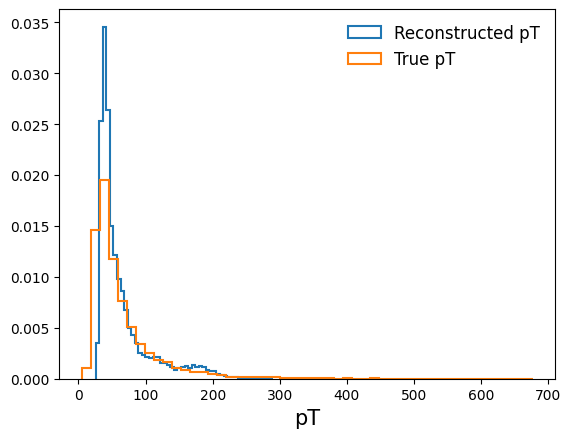

In [13]:
gnn.eval()
with torch.no_grad():
    print(max_pt/3*gnn(jet_dataset_train[1].to(device))[:,1])
    print(max_pt/3*jet_dataset_train[1].x[:,1])

aa = np.array([ max_pt/3*gnn(x.to(device))[:,1].flatten().detach().cpu().numpy() for x in jet_dataset_train]).flatten()
bb = np.array([ max_pt/3*x.x[:,1].flatten().detach().cpu().numpy() for x in jet_dataset_train]).flatten()

# data_feature = jetList[:,:,1]
# then plot the right quantity for the reduced array (merge all constituents together)
plt.hist(aa, bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
plt.hist(bb, bins=50, density=True, histtype='step', fill=False, linewidth=1.5)
plt.legend(["Reconstructed pT", "True pT"], fontsize=12, frameon=False)
plt.xlabel("pT", fontsize=15)
plt.show()